
# Transformer代码实现

参考：

[Attention Is All You Need](https://arxiv.org/pdf/1706.03762.pdf)

[The Illustrated Transformer](http://jalammar.github.io/illustrated-transformer)

[PyTorch官方教程：Sequence-to-Sequence Modeling with nn.Transformer and TorchText](https://pytorch.org/tutorials/beginner/transformer_tutorial.html)

[TF官方教程：理解语言的 Transformer 模型](https://tensorflow.google.cn/tutorials/text/transformer)

## 目录

1. 数据预处理

2. Transformer模型概况

3. 位置编码（positional encoding）

4. 编码器（encoder）

    * 自注意力机制（self attention）

    * 层归一化（layer normalization）、残差连接
    
    * 前馈网络（feed forward）

    * 编码器整体结构
    
5. 解码器（decoder）

6. 注意力掩码机制

7. Transformer模型

8. 模型训练

9. 模型预测

In [1]:
import copy
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
import time
import torch
import torch.nn as nn
import torch.nn.functional as F

from collections import Counter
from langconv import Converter
from nltk import word_tokenize
from torch.autograd import Variable

%matplotlib inline

In [2]:
# 初始化参数设置
PAD = 0                             # padding占位符的索引
UNK = 1                             # 未登录词标识符的索引
BATCH_SIZE = 128                    # 批次大小
EPOCHS = 20                         # 训练轮数
LAYERS = 6                          # transformer中encoder、decoder层数
H_NUM = 8                           # 多头注意力个数
D_MODEL = 256                       # 输入、输出词向量维数
D_FF = 1024                         # feed forward全连接层维数
DROPOUT = 0.1                       # dropout比例
MAX_LENGTH = 60                     # 语句最大长度

TRAIN_FILE = 'nmt/en-cn/train.txt'  # 训练集
DEV_FILE = "nmt/en-cn/dev.txt"      # 验证集
SAVE_FILE = 'save/model.pt'         # 模型保存路径
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 1. 数据预处理

注意：使用中文语料训练Transformer模型时，中文语句一般**以字为单位进行切分**，即无需对中文语句分词。

注意：**同一批次中seq_len相同，不同批次间seq_len可能变化。**

In [3]:
def seq_padding(X, padding=PAD):
    """
    按批次（batch）对数据填充、长度对齐
    """
    # 计算该批次各条样本语句长度
    L = [len(x) for x in X]
    # 获取该批次样本中语句长度最大值
    ML = max(L)
    # 遍历该批次样本，如果语句长度小于最大长度，则用padding填充
    return np.array([
        np.concatenate([x, [padding] * (ML - len(x))]) if len(x) < ML else x for x in X
    ])

def cht_to_chs(sent):
    sent = Converter("zh-hans").convert(sent)
    sent.encode("utf-8")
    return sent

In [4]:
class PrepareData:
    def __init__(self, train_file, dev_file):
        # 读取数据、分词
        self.train_en, self.train_cn = self.load_data(train_file)
        self.dev_en, self.dev_cn = self.load_data(dev_file)
        # 构建词表
        self.en_word_dict, self.en_total_words, self.en_index_dict = \
            self.build_dict(self.train_en)
        self.cn_word_dict, self.cn_total_words, self.cn_index_dict = \
            self.build_dict(self.train_cn)
        # 单词映射为索引
        self.train_en, self.train_cn = self.word2id(self.train_en, self.train_cn, self.en_word_dict, self.cn_word_dict)
        self.dev_en, self.dev_cn = self.word2id(self.dev_en, self.dev_cn, self.en_word_dict, self.cn_word_dict)
        # 划分批次、填充、掩码
        self.train_data = self.split_batch(self.train_en, self.train_cn, BATCH_SIZE)
        self.dev_data = self.split_batch(self.dev_en, self.dev_cn, BATCH_SIZE)

    def load_data(self, path):
        """
        读取英文、中文数据
        对每条样本分词并构建包含起始符和终止符的单词列表
        形式如：en = [['BOS', 'i', 'love', 'you', 'EOS'], ['BOS', 'me', 'too', 'EOS'], ...]
                cn = [['BOS', '我', '爱', '你', 'EOS'], ['BOS', '我', '也', '是', 'EOS'], ...]
        """
        en = []
        cn = []
        with open(path, mode="r", encoding="utf-8") as f:
            for line in f.readlines():
                sent_en, sent_cn = line.strip().split("\t")
                sent_en = sent_en.lower()
                sent_cn = cht_to_chs(sent_cn)
                sent_en = ["BOS"] + word_tokenize(sent_en) + ["EOS"]
                # 中文按字符切分
                sent_cn = ["BOS"] + [char for char in sent_cn] + ["EOS"]
                en.append(sent_en)
                cn.append(sent_cn)
        return en, cn
    
    def build_dict(self, sentences, max_words=5e4):
        """
        构造分词后的列表数据
        构建单词-索引映射（key为单词，value为id值）
        """
        # 统计数据集中单词词频
        word_count = Counter([word for sent in sentences for word in sent])
        # 按词频保留前max_words个单词构建词典
        # 添加UNK和PAD两个单词
        ls = word_count.most_common(int(max_words))
        total_words = len(ls) + 2
        word_dict = {w[0]: index + 2 for index, w in enumerate(ls)}
        word_dict['UNK'] = UNK
        word_dict['PAD'] = PAD
        # 构建id2word映射
        index_dict = {v: k for k, v in word_dict.items()}
        return word_dict, total_words, index_dict

    def word2id(self, en, cn, en_dict, cn_dict, sort=True):
        """
        将英文、中文单词列表转为单词索引列表
        `sort=True`表示以英文语句长度排序，以便按批次填充时，同批次语句填充尽量少
        """
        length = len(en)
        # 单词映射为索引
        out_en_ids = [[en_dict.get(word, UNK) for word in sent] for sent in en]
        out_cn_ids = [[cn_dict.get(word, UNK) for word in sent] for sent in cn]
        # 按照语句长度排序
        def len_argsort(seq):
            """
            传入一系列语句数据(分好词的列表形式)，
            按照语句长度排序后，返回排序后原来各语句在数据中的索引下标
            """
            return sorted(range(len(seq)), key=lambda x: len(seq[x]))
        # 按相同顺序对中文、英文样本排序
        if sort:
            # 以英文语句长度排序
            sorted_index = len_argsort(out_en_ids)
            out_en_ids = [out_en_ids[idx] for idx in sorted_index]
            out_cn_ids = [out_cn_ids[idx] for idx in sorted_index]
        return out_en_ids, out_cn_ids

    def split_batch(self, en, cn, batch_size, shuffle=True):
        """
        划分批次
        `shuffle=True`表示对各批次顺序随机打乱
        """
        # 每隔batch_size取一个索引作为后续batch的起始索引
        idx_list = np.arange(0, len(en), batch_size)
        # 起始索引随机打乱
        if shuffle:
            np.random.shuffle(idx_list)
        # 存放所有批次的语句索引
        batch_indexs = []
        for idx in idx_list:
            """
            形如[array([4, 5, 6, 7]), 
                 array([0, 1, 2, 3]), 
                 array([8, 9, 10, 11]),
                 ...]
            """
            # 起始索引最大的批次可能发生越界，要限定其索引
            batch_indexs.append(np.arange(idx, min(idx + batch_size, len(en))))
        # 构建批次列表
        batches = []
        for batch_index in batch_indexs:
            # 按当前批次的样本索引采样
            batch_en = [en[index] for index in batch_index]
            batch_cn = [cn[index] for index in batch_index]
            # 对当前批次中所有语句填充、对齐长度
            # 维度为：batch_size * 当前批次中语句的最大长度
            batch_cn = seq_padding(batch_cn)
            batch_en = seq_padding(batch_en)
            # 将当前批次添加到批次列表
            # Batch类用于实现注意力掩码
            batches.append(Batch(batch_en, batch_cn))
        return batches

In [5]:
# 示例
# data_mini = PrepareData("./nmt/en-cn/train_mini.txt", "./nmt/en-cn/dev_mini.txt")
# print("*** batch 0, en ***")
# print(data_mini.train_data[0][0])
# print("*** batch 0, chs ***")
# print(data_mini.train_data[0][1])
# print("*** en word to index ***")
# print(data_mini.en_word_dict)
# print("*** chs word to index ***")
# print(data_mini.cn_word_dict)


## 2. Transformer模型概况
  
**Transformer**和**LSTM**的最大区别：LSTM采用迭代（自回归）训练方式，而Transformer可以并行训练，极大加快计算效率。Transformer使用位置编码（positional encoding）理解语言的顺序，使用自注意力机制和全连接层前向计算。   
  
Transformer模型由**编码器**和**解码器**组成，

* **编码器（encoder）**

将自然语言序列映射成为**隐藏层表示**（下图中九宫格），即自然语言序列的数学表达

* **解码器（decoder）**

将隐藏层表示映射为自然语言序列，进而解决各种任务，如情感分类、命名实体识别、语义关系抽取、摘要生成、机器翻译等。

![](./img/transformer.jpg)

![](./img/intuition.jpg)

* **词向量（embedding）**  
  
使用可学习的词向量表（input & output embeddings）将输入、输出索引映射为$d_{model}$-维词向量。词向量表可随机初始化，也可加载预训练词向量，如word2vec、glove等。


In [6]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        # 这里的 vocab 只的是 vocab size，即模型认识
        super(Embeddings, self).__init__()
        # Embedding层
        self.lut = nn.Embedding(vocab, d_model)
        # Embedding维数
        self.d_model = d_model

    def forward(self, x):
        # 返回x的词向量（需要乘以math.sqrt(d_model)）
        return self.lut(x) * math.sqrt(self.d_model)

### 重点！重点！重点！

以上我们定义了一个 pytorch Module，你可以把他看成一个深度学习网络，你可以在这边自定义任何深度学习网络的架构。自定义 pytorch Module 的方法很简单，只需要继承 `nn.Module`，而后重写 `forward(self, x)` 函数即可。正如上面这个代码所示。

`forward()` 函数即前向传播，你希望你定义的这个深度学习网络接收一个参数 `x`，而后输出一个output `self.lut(x) * math.sqrt(self.d_model)`.

要使用 `forward()` 函数的话，只需要采用实例的 `__call__` 方法即可，即：`instance()`。下面是一个例子：

In [13]:
my_embedding_layer = Embeddings(d_model=8, vocab=6)
sample_input = torch.tensor([1,2,3])
print(my_embedding_layer(sample_input))

tensor([[-2.4886,  3.4050, -0.2312, -0.6782,  2.4030, -0.7375,  0.9836,  2.5269],
        [-7.3841, -3.7174,  0.1187,  0.1316,  1.4032,  4.9225,  1.6486,  4.9791],
        [ 4.2986,  1.4090, -3.4350,  5.7761,  0.2092, -2.2686,  3.6300,  2.8830]],
       grad_fn=<MulBackward0>)


## 3. 位置编码

由于训练Transformer模型时，序列输入采用并行方式，因此缺少单词的位置信息，通过在Transformer的输入中加入单词位置编码信息，使Transformer能够识别语句中单词的位置关系。   
  
**位置编码（positional encoding）**：位置编码向量与词向量维度相同，$\text{max seq len} \times \text{embedding dim}$。   

  
Transformer原文中使用正、余弦函数的线性变换对单词位置编码：   
  
$$\text{PE}_{pos, 2i} = \sin \left( \frac{pos}{10000^{2i / d_{\text{model}}}} \right) \\ 
\text{PE}_{(pos,2i + 1)} = \cos \left( \frac{pos}{10000^{2i / d_{\text{model}}}} \right)\tag{eq.1}$$  
  
其中，$pos \in [0, \text{max_seq_len})$表示单词在语句中的位置，$i \in [0, \text{embedding_dim})$表示词向量维度。位置编码函数的波长在$[2 \pi, 10000 \times 2 \pi]$区间内变化，语句中每一个单词位置沿词向量维度由周期不同的正、余弦函数交替取值组合，生成独一纹理信息，从而使模型学到位置间的依赖关系和自然语言的时序特性。   

In [14]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        # 位置编码矩阵，维度[max_len, embedding_dim]
        pe = torch.zeros(max_len, d_model, device=DEVICE)
        # 单词位置
        position = torch.arange(0.0, max_len, device=DEVICE)
        position.unsqueeze_(1)
        # 使用exp和log实现幂运算
        div_term = torch.exp(torch.arange(0.0, d_model, 2, device=DEVICE) * (- math.log(1e4) / d_model))
        div_term.unsqueeze_(0)
        # 计算单词位置沿词向量维度的纹理值
        pe[:, 0 : : 2] = torch.sin(torch.mm(position, div_term))
        pe[:, 1 : : 2] = torch.cos(torch.mm(position, div_term))
        # 增加批次维度，[1, max_len, embedding_dim]
        pe.unsqueeze_(0)
        # 将位置编码矩阵注册为buffer(不参加训练)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # 将一个批次中语句所有词向量与位置编码相加
        # 注意，位置编码不参与训练，因此设置requires_grad=False
        x += Variable(self.pe[:, : x.size(1), :], requires_grad=False)
        return self.dropout(x)

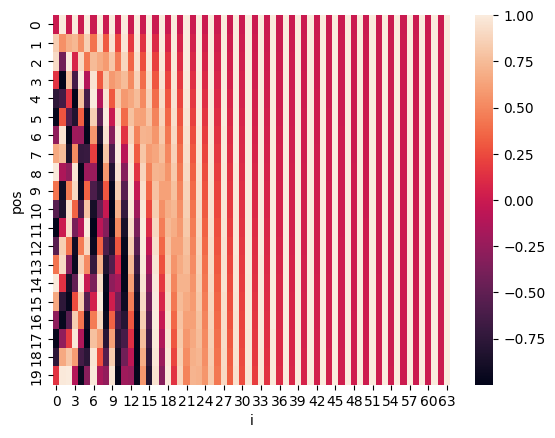

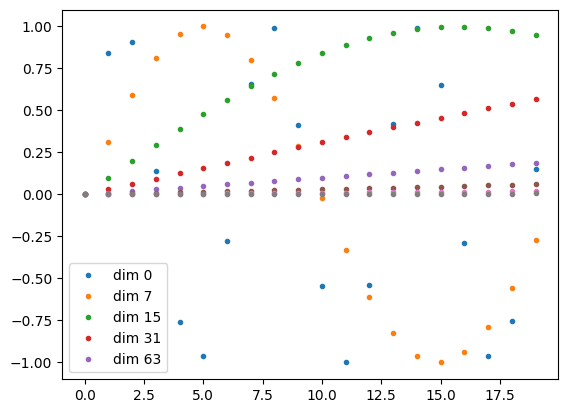

In [15]:
emb_dim = 64
max_seq_len = 100
seq_len = 20

pe = PositionalEncoding(emb_dim, 0, max_seq_len)
positional_encoding = pe(torch.zeros(1, seq_len, emb_dim, device=DEVICE))
plt.figure()
sns.heatmap(positional_encoding.squeeze().to("cpu"))
plt.xlabel("i")
plt.ylabel("pos")
plt.show()

plt.figure()
y = positional_encoding.to("cpu").numpy()
plt.plot(np.arange(seq_len), y[0, :, 0 : 64 : 8], ".")
plt.legend(["dim %d" % p for p in [0, 7, 15, 31, 63]])
plt.show()

## 4. 编码器
  
Transformer的编码器能够独立完成一些主流自然语言处理任务, 如情感分类、语义关系分析、命名实体识别等。Transformer编码器单元结构：

![](./img/encoder.jpg)

### 4.1 自注意力机制

![](./img/attention_0.jpg)

![](./img/attention_1.jpg)

![](./img/attention_2.jpg)

* **$\sqrt{d_{k}}$归一化**  
  
假设$\mathbf{q}$、$\mathbf{k}$为均值0、方差1的独立随机变量，其点积注意力$\mathbf{q} \cdot \mathbf{k} = \sum_{i=1}^{d_k}{\mathbf{q}_{i} \mathbf{k}_{i}}$的均值和方差分别为0、$d_{k}$。通过$\sqrt{d_{k}}$缩放，使softmax结果更稳定（防止单词-单词间的点积注意力差异太大），便于反向传播时梯度平衡。


In [16]:
def clones(module, N):
    """
    克隆基本单元，克隆的单元之间参数不共享
    """
    return nn.ModuleList([
        copy.deepcopy(module) for _ in range(N)
    ])

In [17]:
def attention(query, key, value, mask=None, dropout=None):
    """
    Scaled Dot-Product Attention（方程（4））
    """
    # q、k、v向量长度为d_k
    d_k = query.size(-1)
    # 矩阵乘法实现q、k点积注意力，sqrt(d_k)归一化
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    # 注意力掩码机制
    if mask is not None:
        scores = scores.masked_fill(mask==0, -1e9)
    # 注意力矩阵softmax归一化
    p_attn = F.softmax(scores, dim=-1)
    # dropout
    if dropout is not None:
        p_attn = dropout(p_attn)
    # 注意力对v加权
    return torch.matmul(p_attn, value), p_attn

In [18]:
class MultiHeadedAttention(nn.Module):
    """
    Multi-Head Attention（编码器（2））
    """
    def __init__(self, h, d_model, dropout=0.1):
        super(MultiHeadedAttention, self).__init__()
        """
        `h`：注意力头的数量
        `d_model`：词向量维数
        """
        # 确保整除
        assert d_model % h == 0
        # q、k、v向量维数
        self.d_k = d_model // h
        # 头的数量
        self.h = h
        # WQ、WK、WV矩阵及多头注意力拼接变换矩阵WO
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        if mask is not None:
            mask = mask.unsqueeze(1)
        # 批次大小
        nbatches = query.size(0)
        # WQ、WK、WV分别对词向量线性变换，并将结果拆成h块
        query, key, value = [
            l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
            for l, x in zip(self.linears, (query, key, value))
        ]
        # 注意力加权
        x, self.attn = attention(query, key, value, mask=mask, dropout=self.dropout)
        # 多头注意力加权拼接
        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.h * self.d_k)
        # 对多头注意力加权拼接结果线性变换
        return self.linears[-1](x)

### 4.2 层归一化、残差连接

* **层归一化**

层归一化将神经网络中隐藏层归一化为标准正态分布，以加快训练速度

![](./img/layer_norm.jpg)

$$\begin{aligned}
\mu^{l} & = \frac{1}{H} \sum_{i = 1}^{H} x_{i}^{l} \\  
\sigma^{l} & = \sqrt{\frac{1}{H} \sum_{i = 1}^{H} (x_{i}^{l} - \mu^{l})^{2}} \\
\text{LayerNorm}(\mathbf{x}^{l}) & = \alpha \odot \frac{\mathbf{x}^{l} - \mu^{l}}{\sqrt{(\sigma^{l})^{2} + \epsilon}} + \beta
\end{aligned} \tag{5}$$

其中，$\odot$表示Hadamard积，即两个向量对应元素相乘。$\alpha$、$\beta$为可训练参数，以弥补归一化过程损失信息。通常$\alpha$、$\beta$分别初始化为1、0。  

In [19]:
class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        # α、β分别初始化为1、0
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        # 平滑项
        self.eps = eps

    def forward(self, x):
        # 沿词向量方向计算均值和方差
        mean = x.mean(dim=-1, keepdim=True)
        std = x.std(dim=-1, keepdim=True)
        # 沿词向量和语句序列方向计算均值和方差
        # mean = x.mean(dim=[-2, -1], keepdim=True)
        # std = x.std(dim=[-2, -1], keepdim=True)
        # 归一化
        x = (x - mean) / torch.sqrt(std ** 2 + self.eps)
        return self.a_2 * x + self.b_2

* **残差连接**
  
残差连接：训练时，梯度通过捷径直接反向传播至前层

$$\mathbf{x} + \text{SubLayer}(\mathbf{x}) \tag{6}$$

其中，$\text{SubLayer}$表示`Add & Norm`前层模块，如`Multi-Head Attention`、`Feed Forward`。

In [20]:
class SublayerConnection(nn.Module):
    """
    通过层归一化和残差连接，连接Multi-Head Attention和Feed Forward
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        # 层归一化
        x_ = self.norm(x)
        x_ = sublayer(x_)
        x_ = self.dropout(x_)
        # 残差连接
        return x + x_

### 4.3 前馈网络

前馈网络（Feed Forward）为两层线性映射及激活函数

In [21]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.w_1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.w_2(x)
        return x

### 4.4 Transformer编码器整体结构

Transformer编码器基本单元由两个子层组成：第一个子层实现多头**自注意力（self-attention）**机制（Multi-Head Attention）；第二个子层实现全连接前馈网络。计算过程如下：
  
1. **词向量与位置编码**

$$X = \text{EmbeddingLookup}(X) + \text{PositionalEncoding} \tag{2}$$

$$X \in \mathbb{R}^{\text{batch_size} \times \text{seq_len} \times \text{embedding_dim}}$$

2. **自注意力机制**

$$Q = \text{Linear}(X) = X W_{Q}$$

$$K = \text{Linear}(X) = XW_{K} \tag{3}$$

$$V = \text{Linear}(X) = XW_{V}$$

$$X_{\text{attention}} = \text{SelfAttention}(Q, K, V) \tag{4}$$

3. **层归一化、残差连接**

$$X_{\text{attention}} = \text{LayerNorm}(X_{\text{attention}}) \tag{5}$$

$$X_{\text{attention}} = X + X_{\text{attention}} \tag{6}$$  

4. **前馈网络**

$$X_{\text{hidden}} = \text{Linear}(\text{Activate}(\text{Linear}(X_{\text{attention}}))) \tag{7}$$

5. **层归一化、残差连接**

$$X_{\text{hidden}} = \text{LayerNorm}(X_{\text{hidden}})$$

$$X_{\text{hidden}} = X_{\text{attention}} + X_{\text{hidden}}$$

$$X_{\text{hidden}} \in \mathbb{R}^{\text{batch_size} \times \text{seq_len} \times \text{embedding_dim}}$$

Transformer编码器由$N = 6$个编码器基本单元组成。

In [22]:
class EncoderLayer(nn.Module):
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        # SublayerConnection作用连接multi和ffn
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        # d_model
        self.size = size

    def forward(self, x, mask):
        # 将embedding层进行Multi head Attention
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        # attn的结果直接作为下一层输入
        return self.sublayer[1](x, self.feed_forward)

In [23]:
class Encoder(nn.Module):
    def __init__(self, layer, N):
        """
        layer = EncoderLayer
        """
        super(Encoder, self).__init__()
        # 复制N个编码器基本单元
        self.layers = clones(layer, N)
        # 层归一化
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, mask):
        """
        循环编码器基本单元N次
        """
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

## 5. 解码器

![](./img/decoder.jpg)

解码器同样由$N$层解码器基本单元堆叠而成，与编码器基本单元不同的是：在编码器基本单元的多头**自注意力**机制及前馈网络之间插入一个**上下文注意力（context-attention）**机制（Multi-Head Attention）层，用解码器基本单元的自注意力机制输出作为$q$查询编码器的输出，以便解码时，解码器获得编码器的所有输出，即上下文注意力机制的$K$、$V$来自编码器的输出，$Q$来自解码器前一时刻的输出。

编码器和解码器注意力的区别：

![](./img/attention.png)

解码器基本单元的输入、输出：

* 输入：编码器的输出、解码器前一时刻的输出

* 输出：对应当前时刻输出单词的概率分布

此外，解码器的输出（最后一个解码器基本单元的输出）需要经线性变换和softmax函数映射为下一时刻预测单词的概率分布。  

解码器**解码过程**：给定编码器输出（编码器输入语句所有单词的词向量）和解码器前一时刻输出（单词），预测当前时刻单词的概率分布。

注意：训练过程中，编、解码器均可以并行计算（训练语料中已知前一时刻单词）；推理过程中，编码器可以并行计算，解码器需要像RNN一样依次预测输出单词。


In [24]:
class Decoder(nn.Module):
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, memory, src_mask, tgt_mask):
        """
        循环解码器基本单元N次
        """
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

In [25]:
class DecoderLayer(nn.Module):
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        # 自注意力机制
        self.self_attn = self_attn
        # 上下文注意力机制
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)

    def forward(self, x, memory, src_mask, tgt_mask):
        # memory为编码器输出隐表示
        m = memory
        # 自注意力机制，q、k、v均来自解码器隐表示
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        # 上下文注意力机制：q为来自解码器隐表示，而k、v为编码器隐表示
        x = self.sublayer[1](x, lambda x: self.self_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)

In [26]:
class Generator(nn.Module):
    """
    解码器输出经线性变换和softmax函数映射为下一时刻预测单词的概率分布
    """
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        # decode后的结果，先进入一个全连接层变为词典大小的向量
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        # 然后再进行log_softmax操作(在softmax结果上再做多一次log运算)
        return F.log_softmax(self.proj(x), dim=-1)

## 6. 注意力掩码机制

### 6.1 编码器注意力掩码

编码器注意力掩码的目地：使批次中较短语句的填充部分不参与注意力计算。
  
![](./img/attention_mask2.jpg)

模型训练通常按批次进行，同一批次中的语句长度可能不同，因此需要按语句最大长度对短语句进行0填充以补齐长度。语句填充部分属于无效信息，不应参与前向传播，考虑softmax函数特性，

$$\text{softmax}(\mathbf {z})_{i} = {\frac{\exp(z_{i})}{\sum _{j = 1}^{K} \exp(z_{j})}}$$

当$z_{i}$为填充时，可令$z_{i} = - \infty$（一般取很大的负数）使其无效。

$$z_{\text{pad}} = - \infty, \exp(z_{\text{pad}}) = 0$$

![](./img/attention_mask.jpg)

编码器注意力掩码生成伪代码：

```python
# True表示有效；False表示无效（填充位）
mask = src != pad
# 将无效位置为负无穷
scores = scores.masked_fill(~mask, -1e9)
```

### 6.2 解码器注意力掩码


解码器注意力掩码相对于编码器略微复杂，不仅需要将填充部分屏蔽掉，还需要对当前及后续序列进行屏蔽（`subsequent_mask`），即解码器在预测当前时刻单词时，不能知道当前及后续单词内容，因此注意力掩码需要将当前时刻之后的注意力分数全部置为$- \infty$，然后再计算$softmax$，防止发生数据泄露。

subsequent_mask的矩阵形式为一个下三角矩阵，在主对角线右上位置全部为False

![](./img/subsequent_mask.png)


In [27]:
def subsequent_mask(size):
    "Mask out subsequent positions."
    # 设定subsequent_mask矩阵的shape
    attn_shape = (1, size, size)
    # 生成一个右上角(不含主对角线)为全1，左下角(含主对角线)为全0的subsequent_mask矩阵
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    # 返回一个右上角(不含主对角线)为全False，左下角(含主对角线)为全True的subsequent_mask矩阵
    return torch.from_numpy(subsequent_mask) == 0

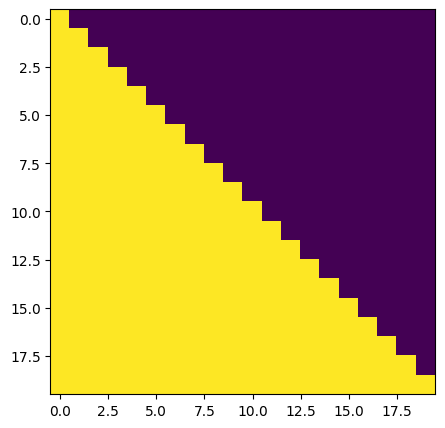

In [28]:
plt.figure(figsize=(5, 5))
plt.imshow(subsequent_mask(20)[0])
plt.show()

In [29]:
class Batch:
    """
    批次类
        1. 输入序列（源）
        2. 输出序列（目标）
        3. 构造掩码
    """
    def __init__(self, src, trg=None, pad=PAD):
        # 将输入、输出单词id表示的数据规范成整数类型
        src = torch.from_numpy(src).to(DEVICE).long()
        trg = torch.from_numpy(trg).to(DEVICE).long()
        self.src = src
        # 对于当前输入的语句非空部分进行判断，bool序列
        # 并在seq length前面增加一维，形成维度为 1×seq length 的矩阵
        self.src_mask = (src != pad).unsqueeze(-2)
        # 如果输出目标不为空，则需要对解码器使用的目标语句进行掩码
        if trg is not None:
            # 解码器使用的目标输入部分
            self.trg = trg[:, : -1]
            # 解码器训练时应预测输出的目标结果
            self.trg_y = trg[:, 1 :]
            # 将目标输入部分进行注意力掩码
            self.trg_mask = self.make_std_mask(self.trg, pad)
            # 将应输出的目标结果中实际的词数进行统计
            self.ntokens = (self.trg_y != pad).data.sum()
    
    # 掩码操作
    @staticmethod
    def make_std_mask(tgt, pad):
        "Create a mask to hide padding and future words."
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & Variable(subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        return tgt_mask

## 7. Transformer模型


In [30]:
class Transformer(nn.Module):
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(Transformer, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator

    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)

    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

    def forward(self, src, tgt, src_mask, tgt_mask):
        # encoder的结果作为decoder的memory参数传入，进行decode
        return self.decode(self.encode(src, src_mask), src_mask, tgt, tgt_mask)

In [31]:
def make_model(src_vocab, tgt_vocab, N=6, d_model=512, d_ff=2048, h = 8, dropout=0.1):
    c = copy.deepcopy
    # 实例化Attention对象
    attn = MultiHeadedAttention(h, d_model).to(DEVICE)
    # 实例化FeedForward对象
    ff = PositionwiseFeedForward(d_model, d_ff, dropout).to(DEVICE)
    # 实例化PositionalEncoding对象
    position = PositionalEncoding(d_model, dropout).to(DEVICE)
    # 实例化Transformer模型对象
    model = Transformer(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout).to(DEVICE), N).to(DEVICE),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout).to(DEVICE), N).to(DEVICE),
        nn.Sequential(Embeddings(d_model, src_vocab).to(DEVICE), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab).to(DEVICE), c(position)),
        Generator(d_model, tgt_vocab)).to(DEVICE)
    
    # This was important from their code. 
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            # 这里初始化采用的是nn.init.xavier_uniform
            nn.init.xavier_uniform_(p)
    return model.to(DEVICE)

## 8. 模型训练

**标签平滑**

训练过程中，采用KL散度损失实现标签平滑（$\epsilon_{ls} = 0.1$）策略，提高模型鲁棒性、准确性和BLEU分数。

标签平滑：输出概率分布由one-hot方式转为真实标签的概率置为`confidence`，其它所有非真实标签概率平分`1 - confidence`。

In [32]:
class LabelSmoothing(nn.Module):
    """
    标签平滑
    """
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(reduction='sum')
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad=False))

tensor([[0.0000, 0.1333, 0.6000, 0.1333, 0.1333],
        [0.0000, 0.6000, 0.1333, 0.1333, 0.1333],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])


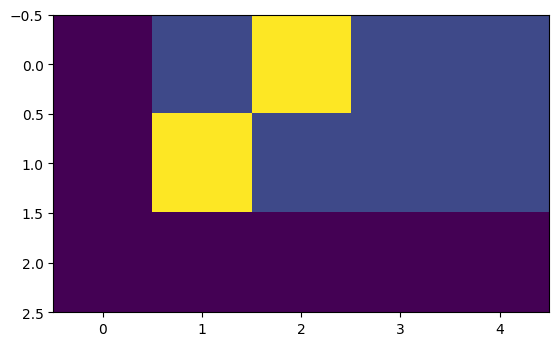

In [33]:
# Label smoothing的例子
crit = LabelSmoothing(5, 0, 0.4)  # 设定一个ϵ=0.4
predict = torch.FloatTensor([[0, 0.2, 0.7, 0.1, 0],
                             [0, 0.2, 0.7, 0.1, 0], 
                             [0, 0.2, 0.7, 0.1, 0]])
v = crit(Variable(predict.log()), 
         Variable(torch.LongTensor([2, 1, 0])))

# Show the target distributions expected by the system.
print(crit.true_dist)
plt.imshow(crit.true_dist)

**计算损失**

In [34]:
class SimpleLossCompute:
    """
    简单的计算损失和进行参数反向传播更新训练的函数
    """
    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt
        
    def __call__(self, x, y, norm):
        x = self.generator(x)
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)), 
                              y.contiguous().view(-1)) / norm
        loss.backward()
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return loss.data.item() * norm.float()

**优化器**

Adam优化器，$\beta_1=0.9、\beta_2=0.98$ 和 $\epsilon = 10^{−9}$，并使用warmup策略调整学习率：  
  
$$ lr = d_{\text{model}}^{−0.5} \min(\text{step_num}^{−0.5}, \text{step_num} \times \text{warmup_steps}^{−1.5})$$  

使用固定步数$\text{warmup_steps}$**先使学习率的线性增长（热身）**，而后随着$\text{step_num}$的增加以$\text{step_num}$的反平方根成比例**逐渐减小学习率**。

In [35]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * (self.model_size ** (-0.5) * min(step ** (-0.5), step * self.warmup ** (-1.5)))
        
def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

主要调节是在 $rate$ 这个函数中，其中
- $model\_size$ 即为 $d_{model}$
- $warmup$ 即为 $warmup\_steps$
- $factor$ 可以理解为初始的学习率

以下对该优化器在**不同模型大小（$model\_size$）**和**不同超参数（$marmup$）值**的情况下的学习率（$lrate$）曲线进行示例。 

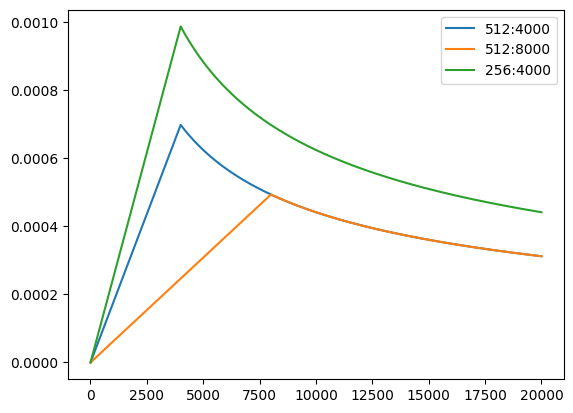

In [36]:
# Three settings of the lrate hyperparameters.
opts = [NoamOpt(512, 1, 4000, None), 
        NoamOpt(512, 1, 8000, None),
        NoamOpt(256, 1, 4000, None)]
plt.plot(np.arange(1, 20000), [[opt.rate(i) for opt in opts] for i in range(1, 20000)])
plt.legend(["512:4000", "512:8000", "256:4000"])

**训练迭代**

接下来，我们创建一个通用的训练和评分功能来跟踪损失。 我们传入一个上面定义的损失计算函数，它也处理参数更新。

In [37]:
def run_epoch(data, model, loss_compute, epoch):
    start = time.time()
    total_tokens = 0.
    total_loss = 0.
    tokens = 0.

    for i , batch in enumerate(data):
        out = model(batch.src, batch.trg, batch.src_mask, batch.trg_mask)
        loss = loss_compute(out, batch.trg_y, batch.ntokens)

        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens

        if i % 50 == 1:
            elapsed = time.time() - start
            print("Epoch %d Batch: %d Loss: %f Tokens per Sec: %fs" % (epoch, i - 1, loss / batch.ntokens, (tokens.float() / elapsed / 1000.)))
            start = time.time()
            tokens = 0

    return total_loss / total_tokens


def train(data, model, criterion, optimizer):
    """
    训练并保存模型
    """
    # 初始化模型在dev集上的最优Loss为一个较大值
    best_dev_loss = 1e5
    
    for epoch in range(EPOCHS):
        # 模型训练
        model.train()
        run_epoch(data.train_data, model, SimpleLossCompute(model.generator, criterion, optimizer), epoch)
        model.eval()

        # 在dev集上进行loss评估
        print('>>>>> Evaluate')
        dev_loss = run_epoch(data.dev_data, model, SimpleLossCompute(model.generator, criterion, None), epoch)
        print('<<<<< Evaluate loss: %f' % dev_loss)
        
        # 如果当前epoch的模型在dev集上的loss优于之前记录的最优loss则保存当前模型，并更新最优loss值
        if dev_loss < best_dev_loss:
            torch.save(model.state_dict(), SAVE_FILE)
            best_dev_loss = dev_loss
            print('****** Save model done... ******')       
            
        print()

In [39]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/kevin/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [43]:
# 数据预处理

if not os.path.exists("./save"):
    os.mkdir("save")
data = PrepareData(TRAIN_FILE, DEV_FILE)
src_vocab = len(data.en_word_dict)
tgt_vocab = len(data.cn_word_dict)
print("src_vocab %d" % src_vocab)
print("tgt_vocab %d" % tgt_vocab)

# 初始化模型
model = make_model(
                    src_vocab, 
                    tgt_vocab, 
                    LAYERS, 
                    D_MODEL, 
                    D_FF,
                    H_NUM,
                    DROPOUT
                )

# 训练
print(">>>>>>> start train")
train_start = time.time()
criterion = LabelSmoothing(tgt_vocab, padding_idx = 0, smoothing= 0.0)
optimizer = NoamOpt(D_MODEL, 1, 2000, torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9,0.98), eps=1e-9))

train(data, model, criterion, optimizer)
print(f"<<<<<<< finished train, cost {time.time()-train_start:.4f} seconds")

src_vocab 5493
tgt_vocab 2537
>>>>>>> start train
Epoch 0 Batch: 0 Loss: 7.983462 Tokens per Sec: 7.111420s
Epoch 0 Batch: 50 Loss: 6.945879 Tokens per Sec: 24.092176s
Epoch 0 Batch: 100 Loss: 6.219329 Tokens per Sec: 23.921907s
>>>>> Evaluate
Epoch 0 Batch: 0 Loss: 5.706156 Tokens per Sec: 25.869282s
<<<<< Evaluate loss: 5.843407
****** Save model done... ******

Epoch 1 Batch: 0 Loss: 5.835004 Tokens per Sec: 25.024916s
Epoch 1 Batch: 50 Loss: 5.464852 Tokens per Sec: 23.739388s
Epoch 1 Batch: 100 Loss: 5.181649 Tokens per Sec: 23.596846s
>>>>> Evaluate
Epoch 1 Batch: 0 Loss: 4.761316 Tokens per Sec: 25.297783s
<<<<< Evaluate loss: 4.969447
****** Save model done... ******

Epoch 2 Batch: 0 Loss: 5.006511 Tokens per Sec: 25.227142s
Epoch 2 Batch: 50 Loss: 4.916019 Tokens per Sec: 23.742947s
Epoch 2 Batch: 100 Loss: 4.667664 Tokens per Sec: 23.605938s
>>>>> Evaluate
Epoch 2 Batch: 0 Loss: 4.171669 Tokens per Sec: 25.102936s
<<<<< Evaluate loss: 4.388628
****** Save model done... *****

## 9. 模型预测


In [44]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    """
    传入一个训练好的模型，对指定数据进行预测
    """
    # 先用encoder进行encode
    memory = model.encode(src, src_mask)
    # 初始化预测内容为1×1的tensor，填入开始符('BOS')的id，并将type设置为输入数据类型(LongTensor)
    ys = torch.ones(1, 1).fill_(start_symbol).type_as(src.data)
    # 遍历输出的长度下标
    for i in range(max_len-1):
        # decode得到隐层表示
        out = model.decode(memory, 
                           src_mask, 
                           Variable(ys), 
                           Variable(subsequent_mask(ys.size(1)).type_as(src.data)))
        # 将隐藏表示转为对词典各词的log_softmax概率分布表示
        prob = model.generator(out[:, -1])
        # 获取当前位置最大概率的预测词id
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word.data[0]
        # 将当前位置预测的字符id与之前的预测内容拼接起来
        ys = torch.cat([ys, 
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
    return ys


def evaluate(data, model):
    """
    在data上用训练好的模型进行预测，打印模型翻译结果
    """
    # 梯度清零
    with torch.no_grad():
        # 在data的英文数据长度上遍历下标
        for i in range(len(data.dev_en)):
            # 打印待翻译的英文语句
            en_sent = " ".join([data.en_index_dict[w] for w in data.dev_en[i]])
            print("\n" + en_sent)
            
            # 打印对应的中文语句答案
            cn_sent = " ".join([data.cn_index_dict[w] for w in data.dev_cn[i]])
            print("".join(cn_sent))
            
            # 将当前以单词id表示的英文语句数据转为tensor，并放如DEVICE中
            src = torch.from_numpy(np.array(data.dev_en[i])).long().to(DEVICE)
            # 增加一维
            src = src.unsqueeze(0)
            # 设置attention mask
            src_mask = (src != 0).unsqueeze(-2)
            # 用训练好的模型进行decode预测
            out = greedy_decode(model, src, src_mask, max_len=MAX_LENGTH, start_symbol=data.cn_word_dict["BOS"])
            # 初始化一个用于存放模型翻译结果语句单词的列表
            translation = []
            # 遍历翻译输出字符的下标（注意：开始符"BOS"的索引0不遍历）
            for j in range(1, out.size(1)):
                # 获取当前下标的输出字符
                sym = data.cn_index_dict[out[0, j].item()]
                # 如果输出字符不为'EOS'终止符，则添加到当前语句的翻译结果列表
                if sym != 'EOS':
                    translation.append(sym)
                # 否则终止遍历
                else:
                    break
            # 打印模型翻译输出的中文语句结果
            print("translation: %s" % " ".join(translation))

In [ ]:
# 预测
# 加载模型
model.load_state_dict(torch.load(SAVE_FILE))
# 开始预测
print(">>>>>>> start evaluate")
evaluate_start  = time.time()
evaluate(data, model)
print(f"<<<<<<< finished evaluate, cost {time.time()-evaluate_start:.4f} seconds")

>>>>>>> start evaluate

BOS look around . EOS
BOS 四 处 看 看 。 EOS
translation: 看 。

BOS hurry up . EOS
BOS 赶 快 ! EOS
translation: 快 点 ！

BOS keep trying . EOS
BOS 继 续 努 力 。 EOS
translation: 继 续 努 力 。

BOS take it . EOS
BOS 拿 走 吧 。 EOS
translation: 走 吧 。

BOS birds fly . EOS
BOS 鸟 类 飞 行 。 EOS
translation: 鸟 儿 飞 。

BOS hurry up . EOS
BOS 快 点 ！ EOS
translation: 快 点 ！

BOS look there . EOS
BOS 看 那 里 。 EOS
translation: 看 那 里 。

BOS how annoying ! EOS
BOS 真 烦 人 。 EOS
translation: 真 是 烦 人 。

BOS get serious . EOS
BOS 认 真 点 。 EOS
translation: 认 为 是 。

BOS once again . EOS
BOS 再 一 次 。 EOS
translation: 再 一 次 。

BOS stay sharp . EOS
BOS 保 持 警 惕 。 EOS
translation: 别 人 。

BOS i won ! EOS
BOS 我 赢 了 。 EOS
translation: 我 赢 了 。

BOS get away ! EOS
BOS 滚 ！ EOS
translation: 走 开 ！

BOS i resign . EOS
BOS 我 放 弃 。 EOS
translation: 我 放 弃 。

BOS how strange ! EOS
BOS 真 奇 怪 。 EOS
translation: 太 奇 了 。

BOS tom UNK . EOS
BOS 汤 姆 脸 红 了 。 EOS
translation: 汤 姆 的 预 订 。

BOS who cares ? EOS
BOS 爱 谁 谁 。 EOS
translation: